In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations

from processor.fdr import FDR_INFO_PROCESSOR, FDR_OHLCV_PREPROCESSOR
from processor.factor.technical import LINEAR_COEFFICENT_FACTOR_PROCESSOR

from analyser.factor import FACTOR_ANALYSER

In [2]:
CFG = {
    "analysis_date": "2023-10-16",
    "LINEAR_COEFFICENT_FACTOR_CFG": {
        "factors": ["Close", "VolumeRotation"],
        "moving_average_window": 10,
        "coef_recent_n": 30,
    },
    "FACTOR_ANALYSIS_CFG": {
        "profit_recent_n": 20,
    },
}

In [3]:
# fdr_info
fdr_info_df = pd.read_csv("./data/fdr_info_df.csv", index_col=0)
fdr_info_processor = FDR_INFO_PROCESSOR(fdr_info_df)

In [4]:
# fdr_ohlcv
fdr_ohlcv_df = pd.read_csv("./data/fdr_ohlcv_df.csv", index_col=0)

fdr_ohlcv_preprocessor = FDR_OHLCV_PREPROCESSOR(fdr_ohlcv_df)
pps_fdr_ohlcv_df = fdr_ohlcv_preprocessor.get_pps_fdr_ohlcv_df()

In [5]:
# split ohlcv

future_ohlcv_df = pps_fdr_ohlcv_df[CFG["analysis_date"] < pps_fdr_ohlcv_df["Date"]].copy()
ohlcv_df = pps_fdr_ohlcv_df[pps_fdr_ohlcv_df["Date"] < CFG["analysis_date"]].copy()

In [6]:
# get linear_coef_factors_df
linear_coefficent_factor_processor = LINEAR_COEFFICENT_FACTOR_PROCESSOR(ohlcv_df, fdr_info_processor)
linear_coef_factors_df = linear_coefficent_factor_processor.get_linear_coef_factor_df(
    CFG["LINEAR_COEFFICENT_FACTOR_CFG"]
)

In [7]:
# Analysis
factor_analyser = FACTOR_ANALYSER(linear_coef_factors_df)

<Axes: >

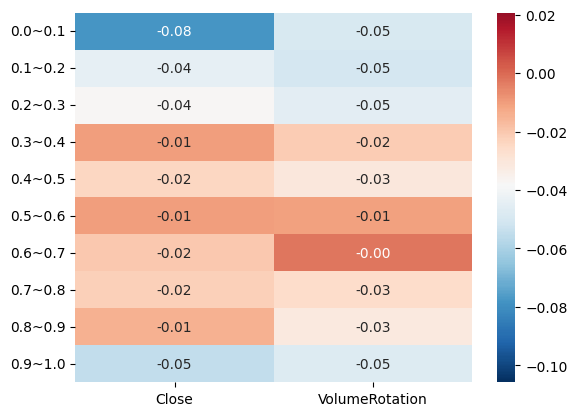

In [8]:
# 1D analysis
profit_row = factor_analyser.get_profit_row(
    factor_analyser.get_recent_ohlcv_df(future_ohlcv_df, CFG["FACTOR_ANALYSIS_CFG"]["profit_recent_n"])
)
sns.heatmap(
    factor_analyser.get_profit_analysis_1d_df(future_ohlcv_df, CFG["FACTOR_ANALYSIS_CFG"]),
    annot=True,
    cmap="RdBu_r",
    vmin=profit_row.quantile(0.2),
    vmax=profit_row.quantile(0.8),
    center=profit_row.mean(),
    fmt=".2f",
)

In [9]:
factors = [col for col in linear_coef_factors_df.columns if col != "StockCode"]
factor_combs = list(combinations(factors, 2))

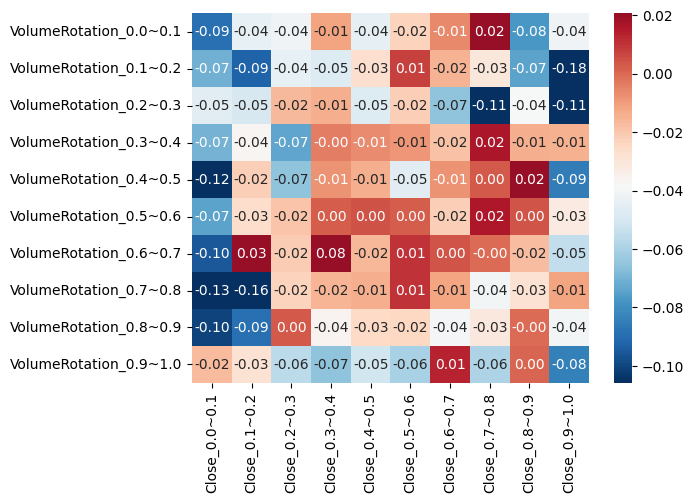

In [10]:
for factor_comb in [comb for comb in factor_combs]:
    profit_analysis_2d_df = factor_analyser.get_profit_analysis_2d_df(
        future_ohlcv_df, CFG["FACTOR_ANALYSIS_CFG"], factor_comb
    )
    sns.heatmap(
        profit_analysis_2d_df,
        annot=True,
        cmap="RdBu_r",
        vmin=profit_row.quantile(0.2),
        vmax=profit_row.quantile(0.8),
        center=profit_row.mean(),
        fmt=".2f",
    )
    plt.show()